<a href="https://colab.research.google.com/github/salvaderron/Artificial-Neural-Network_and_Deep-Learning/blob/main/ANN_%26_DL_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_47']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


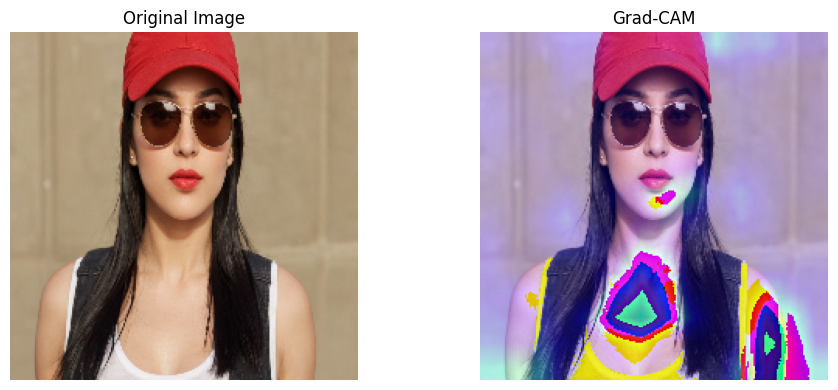

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2

# Load and preprocess image
img_path = 'sample.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
x = np.expand_dims(img_array, axis=0)
x = preprocess_input(x)

# Load model
model = VGG16(weights='imagenet')

# Predict class
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_idx = int(np.argmax(preds[0]))
class_output = model.output[:, class_idx]

# Get the last conv layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a model that maps input to activations and output
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Compute gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)

# Global average pooling on the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# Weight the feature maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose on original image
original_image = cv2.imread(img_path)
original_image = cv2.resize(original_image, (224, 224))
superimposed_img = heatmap_color * 0.4 + original_image

# Convert BGR (OpenCV format) to RGB for matplotlib
superimposed_img_rgb = cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(superimposed_img_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()